# Korean Movie Review Emotion Predict

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from eunjeon import Mecab
import matplotlib.pyplot as plt

In [2]:
#- Load review data
data = pd.read_csv('./data/review_sample_data.csv', encoding='UTF-8')
data = data.drop(['Unnamed: 0'],axis=1)
data.head(10)

,comment,label
0,엔딩크레딧과 함께 흐르는 음악까지 완벽,1
1,그냥 전개가 아예없고 그냥 뮤지컬을 화면으로 옮겼다 라는 느낌? 내용과 하등 관련없...,0
2,마지막 배우들의 미친 연기력에 소름 돋다 눈물이 또르르...안봐야지 하다 봤는데 나...,1
3,팬들을 위한 존중과 배려가 돋보이는 영화이노우에 다케히코가 리얼이후 현실적인 묘사들...,1
4,3D 이녀석 아주 성장했구만~! 열분 IMAX3D로 감상하면 돈 값하는 영화의 맛을...,1
5,체험하는 영화 조금 졸았음,1
6,지루함... 너무나 훌륭한 주제지만 그렇다고 창작물 까지도 좋다고 할 수는 없..,0
7,여기가 천국인가요 ㅠㅠ,1
8,정치가들-국회의원포함-꼭봐야!,1
9,남은 건 영상미 뿐 물이 아름답더라,2


In [3]:
#- Removing word excepting Korean and blank
data['comment'] = data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data['comment'].replace('', np.nan, inplace=True) #- Blank -> Null
print(data.isnull().sum())

comment    6
label      0
dtype: int64


C:\Users\331\AppData\Local\Temp\ipykernel_1360\2763222224.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['comment'] = data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [4]:
#- Removal Null values
data = data.dropna(how = 'any')
print(data.isnull().sum())

comment    0
label      0
dtype: int64


In [5]:
#- Define stopwords
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [6]:
#- Segment sentence by morpheme & Removal stopwords
mecab = Mecab() 

data['comment'] = data['comment'].apply(mecab.morphs)
data['comment'] = data['comment'].apply(lambda x: [item for item in x if item not in stopwords])

In [7]:
#- Split dataset
train_data, test_data = train_test_split(data, test_size = 0.2, stratify=data['label'], random_state = 42)

In [8]:
X_train = train_data['comment'].values
y_train = train_data['label'].values
X_test= test_data['comment'].values
y_test = test_data['label'].values

In [9]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Count of Data by category:")
print(np.asarray((unique_elements, counts_elements)))

Count of Data by category:
[[   0    1    2]
 [ 462 2797  422]]


In [10]:
#- Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [11]:
#- Calculate Vocabulary size
threshold = 2
total_cnt = len(tokenizer.word_index) #- Count of words
rare_cnt = 0 #- counting count of words that appear less than threshold
total_freq = 0 #- Sum of total word frequency of train data
rare_freq = 0 #- Sum of frequency of words that less than threshold

#- key: words value: frequency
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    #- if frequency of words is less than threshold, counting rare word
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('Count of words with frequency 2 or less :', rare_freq)
print('Size of vocabulary list :',total_cnt)
print('Count of rare words that appear less than %s times : %s'%(threshold - 1, rare_cnt))
print("Rate of rare words in Vocabulary list : ", (rare_cnt / total_cnt)*100)
print("Rate of rare words frequency in total words frequency : ", (rare_freq / total_freq)*100)

Count of words with frequency 2 or less : 3971
Size of vocabulary list : 7604
Count of rare words that appear less than 1 times : 3971
Rate of rare words in Vocabulary list :  52.22251446607049
Rate of rare words frequency in total words frequency :  5.531334011227034


In [12]:
#- Resizing vocabulary size
vocab_size = total_cnt - rare_cnt + 2 # Removal words that less than 2 frequency among total words / +2 considering zero padding token and OOV token
print('vocabulary size :',vocab_size)

vocabulary size : 3635


In [13]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Max length of Review : 384
Average length of Review : 19.50312415104591


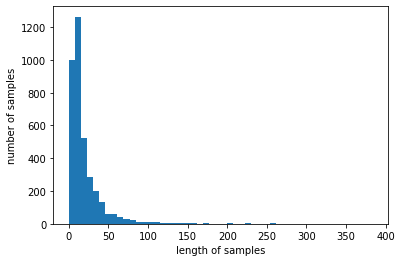

In [14]:
#- Set seqence length
print('Max length of Review :',max(len(content) for content in X_train))
print('Average length of Review :',sum(map(len, X_train))/len(X_train))
plt.hist([len(content) for content in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
#- Set max sequence length (Approximately 99% recommended)
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('Rate of data %s or less length size among total Review data : %s'%(max_len, (count / len(nested_list))*100))

In [17]:
max_len = 350
below_threshold_len(max_len, X_train)

Rate of data 350 or less length size among total Review data : 99.97283346916599


In [18]:
#- Padding
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [19]:
#- Categorization
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [20]:
#- Model build
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

In [27]:
embedding_dim = 100
hidden_units = 128
#num_filters = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
#model.add(Dropout(0.3))
#model.add(Dense(num_filters, activation='relu'))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('Review_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='CategoricalCrossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_cat, epochs=20, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: 0.7013 - acc: 0.7544
Epoch 1: val_acc improved from -inf to 0.76934, saving model to Review_model.h5
92/92 [==============================] - 6s 43ms/step - loss: 0.7013 - acc: 0.7544 - val_loss: 0.5730 - val_acc: 0.7693
Epoch 2/20
91/92 [============================>.] - ETA: 0s - loss: 0.5749 - acc: 0.7977
Epoch 2: val_acc improved from 0.76934 to 0.78426, saving model to Review_model.h5
92/92 [==============================] - 3s 31ms/step - loss: 0.5741 - acc: 0.7979 - val_loss: 0.5391 - val_acc: 0.7843
Epoch 3/20
91/92 [============================>.] - ETA: 0s - loss: 0.3699 - acc: 0.8527
Epoch 3: val_acc did not improve from 0.78426
92/92 [==============================] - 3s 31ms/step - loss: 0.3701 - acc: 0.8526 - val_loss: 0.5770 - val_acc: 0.7693
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss: 0.2635 - acc: 0.9062
Epoch 4: val_acc did not improve from 0.78426
92/92 [======================

In [28]:
loaded_model = load_model('Review_model.h5')
print("\n Accuarcy: %.4f" % (loaded_model.evaluate(X_test, y_test_cat)[1]))

29/29 [==============================] - 1s 20ms/step - loss: 0.5828 - acc: 0.7796

 Accuarcy: 0.7796


In [29]:
rounded_labels=np.argmax(y_test_cat, axis=1)
from sklearn.metrics import classification_report
print(classification_report(rounded_labels, np.argmax(model.predict(X_test), axis=-1)))

29/29 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.41      0.44      0.43       116
           1       0.84      0.89      0.87       700
           2       0.30      0.16      0.21       105

    accuracy                           0.75       921
   macro avg       0.52      0.50      0.50       921
weighted avg       0.73      0.75      0.74       921



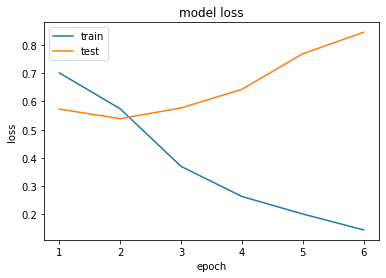

In [30]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
import re

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = 350)
  pre_cat = np.argmax(loaded_model.predict(pad_new), axis=-1)
  socre = np.max(loaded_model.predict(pad_new)) # Using highest predict score 
  pre_value = pre_cat[0]

  if pre_value == 0:
    print("This review is predicted to be 'Negative' at %.5f%%"%socre)
  elif pre_value == 1:
    print("This review is predicted to be 'Positive' at %.5f%%"%socre)
  elif pre_value == 2:
    print("This review is predicted to be 'Normal' at %.5f%%"%socre)

In [34]:
sample_review_0 = '이 영화 너무 재밌다~~!!'
sample_review_1 = '이거 보지 마세요 진짜 재미 없어요'
sample_review_2 = '표값 아까움'
sample_review_3 = '초반부 제외하고 적당히 볼만해요'
sample_review_4 = '너무 몰입해서 봤네요 시간가는 줄 몰랐음'

In [35]:
sentiment_predict(sample_review_0)
sentiment_predict(sample_review_1)
sentiment_predict(sample_review_2)
sentiment_predict(sample_review_3)
sentiment_predict(sample_review_4)

1/1 [==============================] - 0s 27ms/step
This review is predicted to be 'Positive' at 0.92082%
1/1 [==============================] - 0s 24ms/step
This review is predicted to be 'Negative' at 0.45294%
1/1 [==============================] - 0s 23ms/step
This review is predicted to be 'Positive' at 0.41242%
1/1 [==============================] - 0s 23ms/step
This review is predicted to be 'Positive' at 0.46914%
1/1 [==============================] - 0s 23ms/step
This review is predicted to be 'Positive' at 0.82693%
